In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
sns.set()
import re

import nltk
from nltk.stem.porter import *
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

import cv2

from wordcloud import WordCloud
from PIL import Image

from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

### Data Load

In [2]:
wine_reviews = pd.read_csv("./input/winemag-data-130k-v2.csv", index_col=0)

In [3]:
wine_reviews.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [4]:
wine_reviews = wine_reviews.drop(["taster_twitter_handle","taster_name","region_2"],axis=1)
#wine_reviews = wine_reviews.dropna(axis=0)
#wine_reviews = wine_reviews.reset_index(drop=True)
wine_reviews.shape

(129971, 10)

In [5]:
wine_reviews.isnull().sum()

country           63
description        0
designation    37465
points             0
price           8996
province          63
region_1       21247
title              0
variety            1
winery             0
dtype: int64

### Proprecess, stemmiing, remove_stopword

In [7]:
def proprecess_text(text):
    text = re.sub("[^a-zA-Z]",' ',text)
    text = text.strip(" ")   # Remove whitespace resulting from above
    text = re.sub(r' +', ' ', text)   # Remove redundant spaces
    return text

def stemming(df):
    tokenized_text = df.apply(lambda x: x.split())
    stemmer = PorterStemmer()
    tokenized_text = tokenized_text.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
    for i in tokenized_text.index:
        tokenized_text[i] = ' '.join(tokenized_text[i])
    return tokenized_text

def remove_stop_word(df):
    stop = stopwords.words("english")
    df = df.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop) ]))
    return df

In [8]:
# #특수문자, 영어, 여백 제거
wine_reviews['description']= wine_reviews['description'].apply(lambda x: proprecess_text(x)) 
# #stop word 제거
wine_reviews['description'] = remove_stop_word(wine_reviews['description'])
# #stemming : 원형화
wine_reviews['description'] = stemming(wine_reviews['description'])
wine_reviews_prepro.to_csv('./input/wine_reviews_prepro.csv',index=False,header=False)
wine_reviews_prepro= pd.read_csv('./input/wine_reviews_prepro.csv',names =['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'title', 'variety', 'winery'] )

In [12]:
wine_reviews_prepro.variety.describe()

count         129970
unique           707
top       Pinot Noir
freq           13272
Name: variety, dtype: object

In [13]:
wine_reviews_prepro.variety.value_counts()

Pinot Noir                  13272
Chardonnay                  11753
Cabernet Sauvignon           9472
Red Blend                    8946
Bordeaux-style Red Blend     6915
                            ...  
Misket                          1
Biancolella                     1
Torontel                        1
Ondenc                          1
Ryzlink Rýnský                  1
Name: variety, Length: 707, dtype: int64

In [14]:
wine_reviews_prepro.province.describe()

count         129908
unique           425
top       California
freq           36247
Name: province, dtype: object

### Wine data variety,province distribution

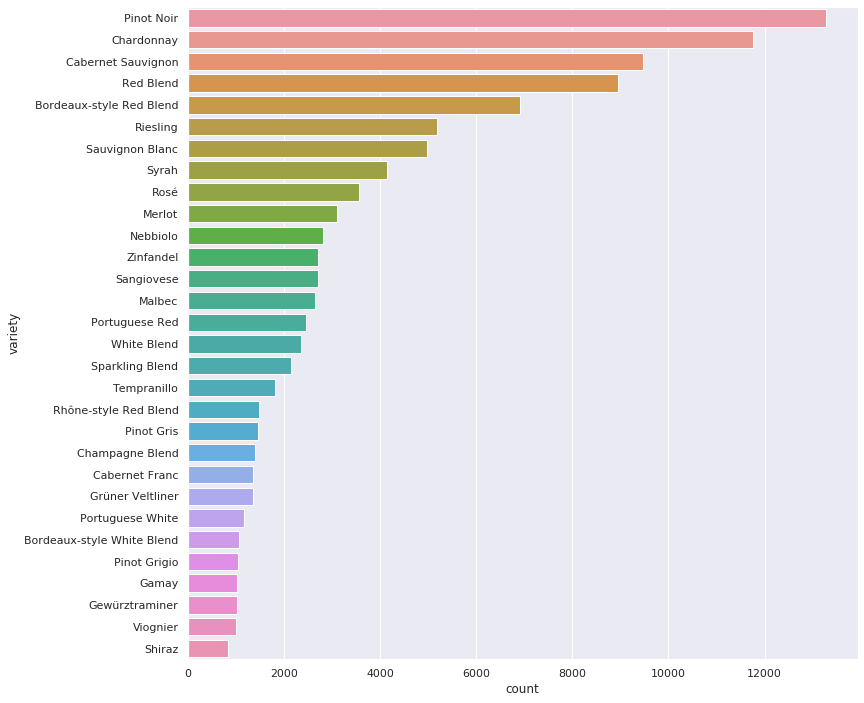

In [15]:
'''
    몇개의 상위 class에 data가 몰려있다.
'''
plt.figure(figsize=(12,12))
cat_freq = wine_reviews.variety.value_counts().head(30)
sns.countplot(y="variety", data=wine_reviews, order=cat_freq.index)

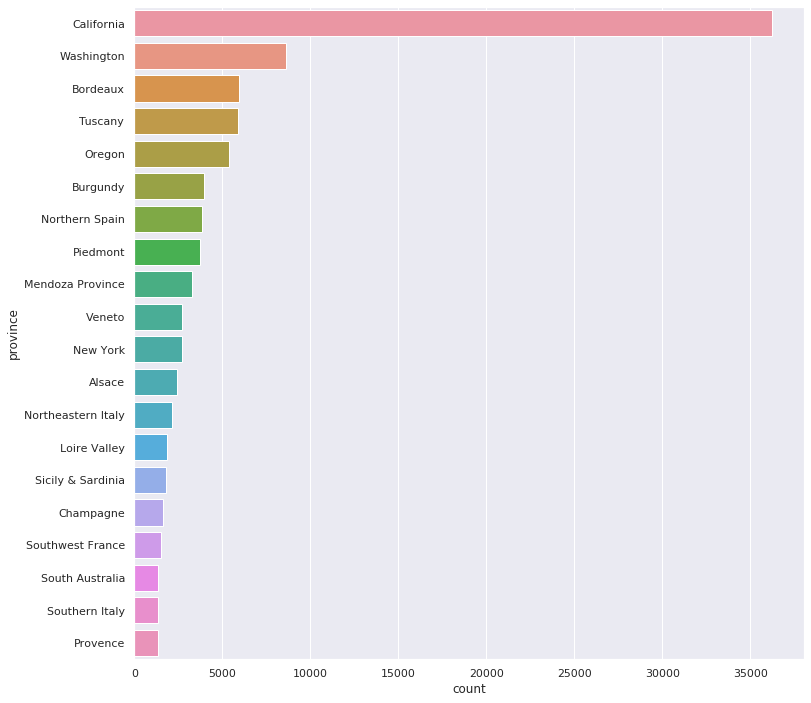

In [16]:
plt.figure(figsize=(12,12))
sns.countplot(y="province", data = wine_reviews, order = wine_reviews.province.value_counts().head(20).index)

### Variety, province Label 구성 check simple example

In [9]:
variety_label = wine_reviews_prepro.variety.value_counts().head(30)
variety_label_one_hot_encoded = pd.get_dummies(variety_label)
variety_target = np.argmax(np.array(variety_label_one_hot_encoded),axis=1)
# province_label = wine_reviews_prepro.province.value_counts().head(20)
# province_label_one_hot_encoded = pd.get_dummies(province_label)
# province_target = np.argmax(np.array(province_label_one_hot_encoded),axis=1)

In [10]:
variety_target

array([29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13,
       12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0])

In [11]:
for i in range(3):
    print(wine_reviews.description[i])

aroma includ tropic fruit broom brimston dri herb the palat overli express offer unripen appl citru dri sage alongsid brisk acid
thi ripe fruiti wine smooth still structur firm tannin fill juici red berri fruit freshen acid It alreadi drinkabl although certainli better
tart snappi flavor lime flesh rind domin some green pineappl poke crisp acid underscor flavor the wine stainless steel ferment


In [12]:
for i in range(3):
    print(wine_reviews_prepro.description[i])

aroma includ tropic fruit broom brimston dri herb the palat overli express offer unripen appl citru dri sage alongsid brisk acid
thi ripe fruiti wine smooth still structur firm tannin fill juici red berri fruit freshen acid It alreadi drinkabl although certainli better
tart snappi flavor lime flesh rind domin some green pineappl poke crisp acid underscor flavor the wine stainless steel ferment


### province,variety Label 구성

In [61]:
pd_province = wine_reviews_prepro[wine_reviews_prepro['province'].isin([word for word in wine_reviews_prepro.province.value_counts().head(20).index])]
pd_province = pd_province.drop(["country","designation","points","price","region_1","title","winery","variety"],axis=1)

In [62]:
pd_variety = wine_reviews_prepro[wine_reviews_prepro['variety'].isin([word for word in wine_reviews_prepro.variety.value_counts().head(30).index])]
pd_variety = pd_variety.drop(["country","designation","points","price","region_1","title","winery","province"],axis=1)

In [63]:
pd_province.to_csv('./input/province.csv',index=False,header=False)
pd_variety.to_csv('./input/variety.csv',index=False,header=False)
province= pd.read_csv('./input/province.csv',names =['description','province'] )
variety= pd.read_csv('./input/variety.csv',names =['description','variety'] )

In [73]:
train, test, train_labels, test_labels, train_masks, test_masks = train_test_split(input_ids, input_labels, attention_masks, test_size=0.25, random_state=123)
train2, test2, train_labels2, test_labels2,  = train_test_split(description, input_labels, test_size=0.25, random_state=123)

train = torch.tensor(train)
train_masks = torch.tensor(train_masks)
train_labels = torch.tensor(train_labels)

dataset = TensorDataset(train, train_labels, train_masks)
dataloader = DataLoader(dataset,batch_size=1)

### WordCloud

In [93]:
word_des, _ = train_test_split(np.array(variety["description"]), test_size=0.25, random_state=123)
word_text=[]
for index in specific_labels_index:
    word_text.append(word_des[index])

In [95]:
alice_mask = np.array(Image.open("./input/wine.png"))
alice_mask = alice_mask[:, :, 0]
for i in range(1104):
    for j in range(920):
        if alice_mask[i][j]==254:
            alice_mask[i][j]=255

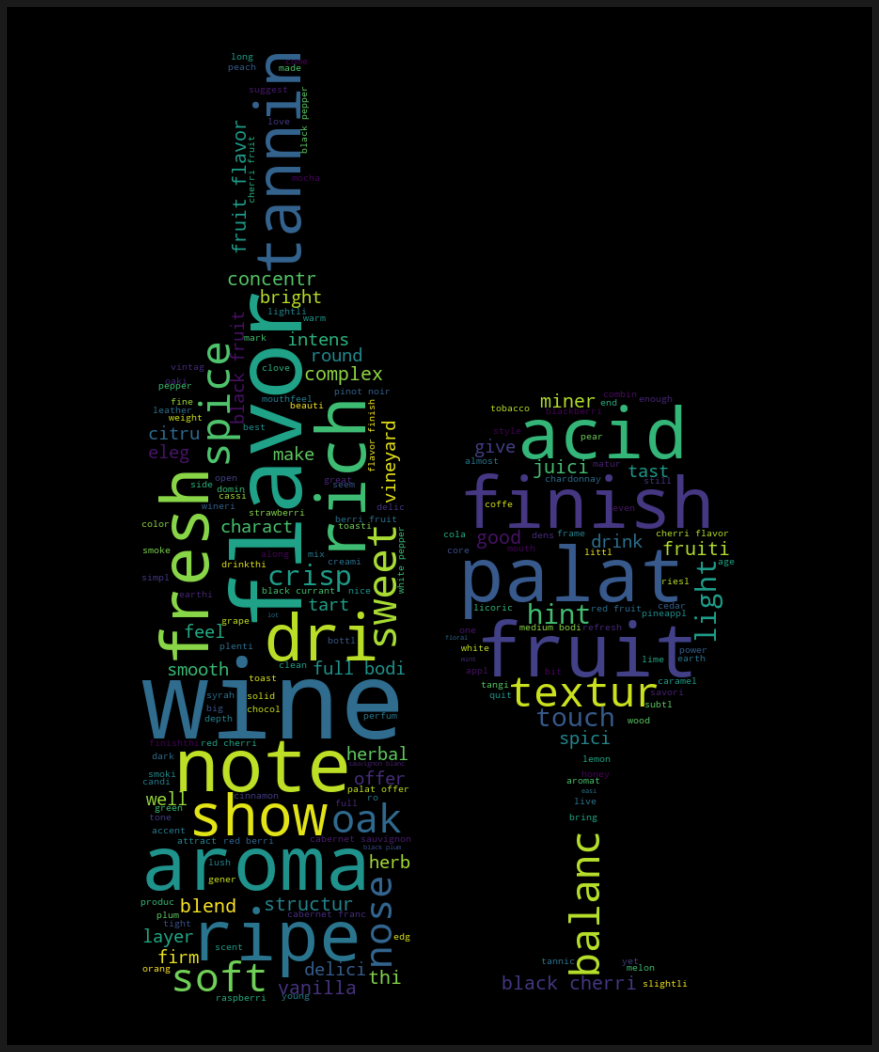

In [96]:
f = open("./input/word_text.txt", 'w')
for i in range(len(word_text)):
    f.write(word_text[i])
f.close()

text=open('./input/word_text.txt').read()
        
wordcloud = WordCloud(
    width = 800,
    height = 800,
    prefer_horizontal = 0.9999,
    min_font_size=5,
    mask = alice_mask
)

wordcloud = wordcloud.generate(text)
plt.figure(figsize=(20,15), facecolor='k')
#plt.imshow(wordcloud)
plt.imshow(wordcloud,interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
#plt.tight_layout(pad=0)
plt.show()

In [98]:
# wordcloud(
# names(ListWordCount),
# freq=ListWordCount,
# scale=c(5,0.2), #빈도가 가장 큰 단어와 가장 빈도가 작은단어 폰사 사이 크기
# rot.per=0.1, #90도 회전해서 보여줄 단어 비율
# min.freq=3, max.words=100, # 빈도 3이상, 100미만
# random.order=F, # True : 랜덤배치, False : 빈도수가 큰단어를 중앙에 배치
# random.color=T, # True : 색랜덤, False : 빈도순
# colors=brewer.pal(11, "Paired"), #11은 사용할 색상개수, 두번째는 색상타입이름
# family="font")